# Parallel plotting with IPython

In this notebook, we demonstrate `parallel_plot`,
a proxy function for computing partial plots in parallel,
and rejoining data as transparent PNGs on the Client.

In [1]:
from IPython import parallel
import  os
#os.environ['PATH'] = '/usr/local/ossh/bin:%s' % os.environ['PATH']
rc = parallel.Client(profile="mpi")

Give each engine her rank

In [2]:
import glob
n = len(glob.glob('poisson_het_2d*.h5'))
eall = rc[:n]
eall.scatter('rank', range(n), flatten=True)
eall['size'] = n

In [3]:
import os
%px cd {os.getcwd()}

[stdout:0] /home/cekees/proteus-notebooks
[stdout:1] /home/cekees/proteus-notebooks
[stdout:2] /home/cekees/proteus-notebooks
[stdout:3] /home/cekees/proteus-notebooks


Generate some x, y scatter data on each engine.

[output:0]

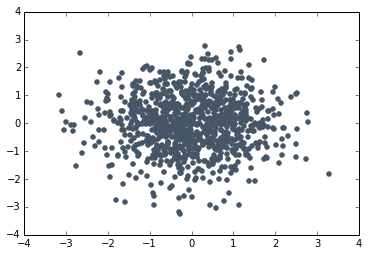

[output:1]

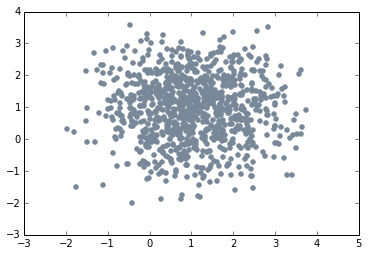

[output:2]

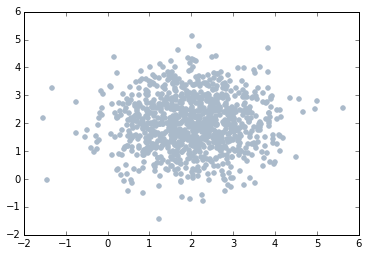

[output:3]

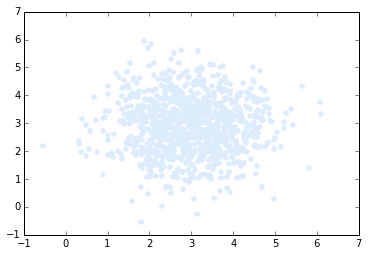

In [4]:
%%px
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x,y = np.random.normal(rank, 1, (2,1000))

r = 20 + int((rank + 1) * 200 / size)
g = r + 16
b = g + 16
color = '#%06x' % ( (r << 16) + (g << 8) + b )

plt.scatter(x, y, color=color);

Load our parallel plotting function:

In [5]:
from parplot import parallel_plot

And do a parallel scatter plot.
The partial plots will be displayed as they arrive.
`xlim` and `ylim` must be specified for the plots to be properly aligned.
The `imshow` flag indicates that the resulting plot should be shown with `plt.imshow` instead of displaying the raw PNG data.
This trades some interpolation quality for axes and ticks.

In [6]:
ref = parallel.Reference
pngdata = parallel_plot(eall, 'scatter', ref('x'), ref('y'),
              color=ref('color'),
              alpha=0.5,
              xlim=(-3,6),
              ylim=(-3,6),
              imshow=True,
)


Now we can try it with something real. We are going to make a contour plot of a a distributed mesh.

First, let's load a sub-grid on each engine

In [7]:
%%px
import tables
mesh = tables.openFile("poisson_het_2d%i.h5" % rank, "r")
triangles = mesh.root.elementsSpatial_Domain0
nodes = mesh.root.nodesSpatial_Domain0
nodalDOF = mesh.root.u01

Check out the sub-grid, as plotted on each engine:

[output:0]

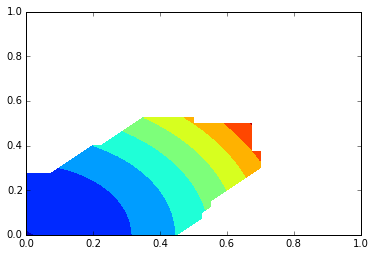

[output:1]

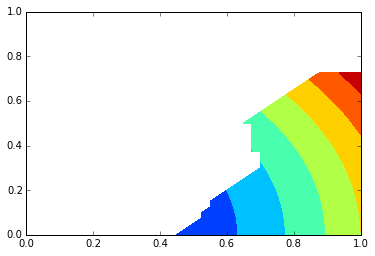

[output:2]

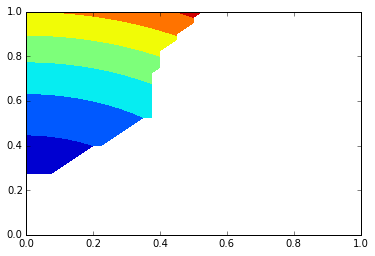

[output:3]

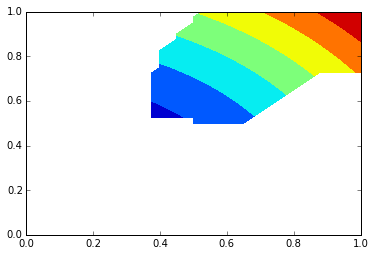

In [8]:
%%px
plt.tricontourf(nodes[:,0],nodes[:,1],triangles,nodalDOF)
plt.xlim(0,1)
plt.ylim(0,1);

Now compute the partial plots remotely, combining the final image locally:

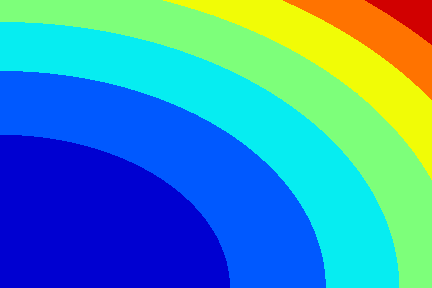

In [9]:
import numpy as np

X = ref('nodes[:,0]')
Y = ref('nodes[:,1]')
t = ref('triangles')
dof = ref('nodalDOF')

pngdata = parallel_plot(eall,
              'tricontourf', X, Y, t, dof,
              levels=np.linspace(-1e-3, 2, 8),
              xlim=(0,1),
              ylim=(0,1),
)
